In [1]:
import itertools
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

PROJECT_DIR = os.path.dirname(os.getcwd())
if PROJECT_DIR not in sys.path:
    sys.path.insert(0, PROJECT_DIR)

from chord_recognition.cache import HDF5Cache
from chord_recognition.models.deep_harmony import deep_harmony
from chord_recognition.dataset import ChromaDataset, prepare_datasource, undersample_dataset, StackedFrameDataset
from chord_recognition.utils import Rescale, one_hot
from chord_recognition.train import get_weighted_random_sampler, Solver

torch.manual_seed(2020)
RANDOM_STATE = 42

%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 5)

%load_ext autoreload
%autoreload 2

In [ ]:
# experiment 6.3
# LSTM with 3 layers but with 128 hidden dims including layernorm

In [2]:
# Exp6
window_size = 8192
hop_length = 4410
context_size = 7
seq_length = 100
target_length = 15

#ds = prepare_datasource(('beatles', 'zweieck', 'queen', 'robbie_williams'))
ds = prepare_datasource(('beatles',))
cache = HDF5Cache(os.path.join(PROJECT_DIR, 'spectrogram_ann_cache.hdf5'))
dataset = StackedFrameDataset(
    datasource=ds,
    seq_length=seq_length,
    target_length=target_length,
    context_size=context_size,
    window_size=window_size,
    hop_length=hop_length,
    cache=cache)

In [3]:
# Split dataset into train/val
indices = np.arange(len(dataset))
idx_train, idx_val = train_test_split(
    indices, test_size=0.2, random_state=RANDOM_STATE)

In [4]:
# Calculate TRAIN_MEAN, TRAIN_STD
X_train_temp = np.hstack([xi.reshape(xi.shape[1], xi.shape[0] * xi.shape[2])
                          for xi,_ in dataset[idx_train]])
TRAIN_MEAN = X_train_temp.mean(axis=1).reshape(-1, 1)
TRAIN_STD = X_train_temp.std(axis=1).reshape(-1, 1)

del X_train_temp

In [5]:
train_data = Subset(dataset, idx_train)
val_data = Subset(dataset, idx_val)
transform = transforms.Compose([
    # Rescale inputs to have a mean of 0 and std of 1
    # It must speed up the convergence
    Rescale(TRAIN_MEAN, TRAIN_STD),
])
train_data.dataset.transform = transform
val_data.dataset.transform = transform

In [6]:
batch_size = 16

# Split dataset into train/val datasets
loader_train = DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=0)
loader_val = DataLoader(
    dataset=val_data,
    num_workers=0,
    batch_size=batch_size)

dataloaders = {
    "train": loader_train,
    "val": loader_val
}

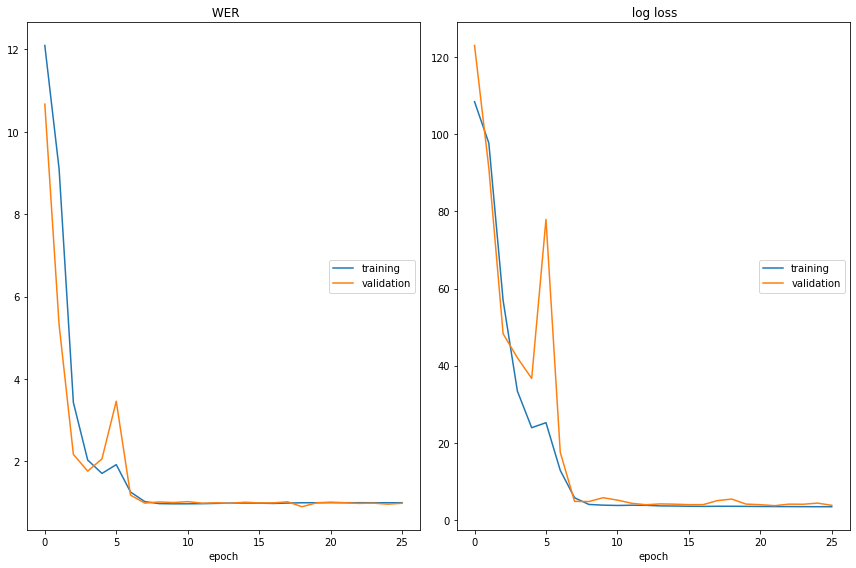

 WER
	training         	 (min:    0.971, max:   12.095, cur:    0.998)
	validation       	 (min:    0.900, max:   10.672, cur:    0.985)
 log loss
	training         	 (min:    3.432, max:  108.422, cur:    3.432)
	validation       	 (min:    3.710, max:  123.003, cur:    3.806)


KeyboardInterrupt: 

In [7]:
model = deep_harmony(n_rnn_layers=3)
if torch.cuda.is_available():
    model.cuda()

learning_rate = 1e-3
epochs=30
weight_decay = 0
optimizer = optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    betas=(0.9, 0.999),
    weight_decay=weight_decay)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer=optimizer,
    max_lr=1e-3,
    final_div_factor=1e6,
    steps_per_epoch=len(loader_train),
    epochs=epochs,
    anneal_strategy='linear',
)

solver = Solver(
    model=model,
    optimizer=optimizer,
    dataloaders=dataloaders,
    scheduler=scheduler,
    trained_model_name="deep_auditory_v2_exp6_3.pth",
    epochs=epochs)
solver.train()